In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
df = pd.read_csv('df.csv')

In [3]:
del df['Unnamed: 0']

In [4]:
df.head()

,Ski Day,valid_tickets
0,2016-12-07,112
1,2016-12-08,1769
2,2016-12-09,4230
3,2016-12-10,5952
4,2016-12-11,5451


In [5]:
df.rename(columns={'Ski Day': 'ski_day', 'valid_tickets': 'tickets'}, inplace=True)

In [6]:
df['ski_day'] = pd.to_datetime(df['ski_day'])

In [7]:
missing_values = df.isnull().sum()
print("\nMissing Values:")
print(missing_values)


Missing Values:
ski_day    0
tickets    0
dtype: int64


In [8]:
df

,ski_day,tickets
0,2016-12-07,112
1,2016-12-08,1769
2,2016-12-09,4230
3,2016-12-10,5952
4,2016-12-11,5451
...,...,...
678,2022-02-01,4
679,2022-02-02,4
680,2022-02-03,4
681,2022-02-04,4


In [9]:
df['week'] = df['ski_day'].dt.to_period('W').apply(lambda r: r.start_time)
df['day_of_week_text'] = df['ski_day'].dt.day_name()
# Extract the month and year for monthly aggregation
df['month_text'] = df['ski_day'].dt.month_name()
df['year'] = df['ski_day'].dt.year
df['month'] = df['ski_day'].dt.month
df['day_of_week'] = df['ski_day'].dt.dayofweek 
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int) 
df['day_of_year'] = df['ski_day'].dt.dayofyear


## EDA

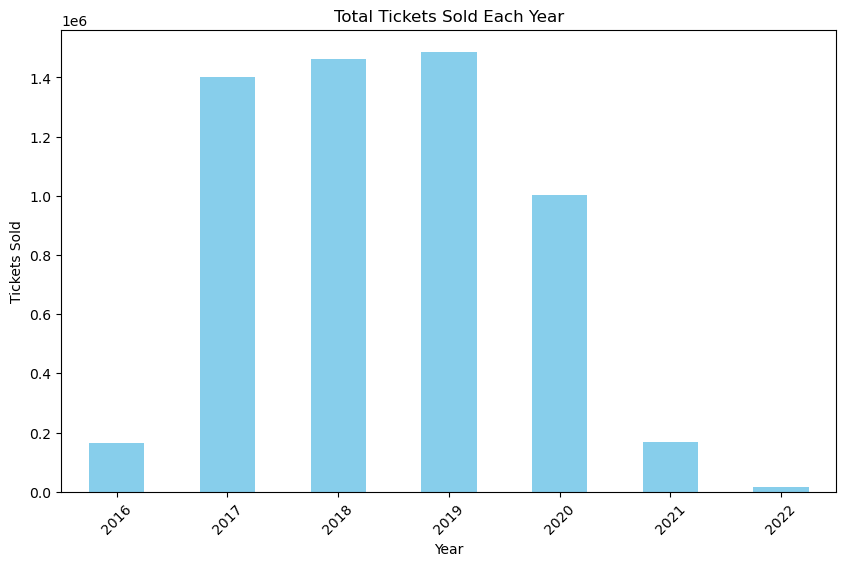

In [10]:
# Group by the 'year' and sum the 'tickets' sold each year
tickets_by_year = df.groupby('year')['tickets'].sum()
# Plot the result
plt.figure(figsize=(10, 6))
tickets_by_year.plot(kind='bar', color='skyblue')
plt.title('Total Tickets Sold Each Year')
plt.xlabel('Year')
plt.ylabel('Tickets Sold')
plt.xticks(rotation=45)
plt.show()

We have data beween 2016 and 2022, where sales is almost the same between 2017 and 2020, but very low in 2016 (data issue could be)
and low in 2021 and 2022 (possibly corona)

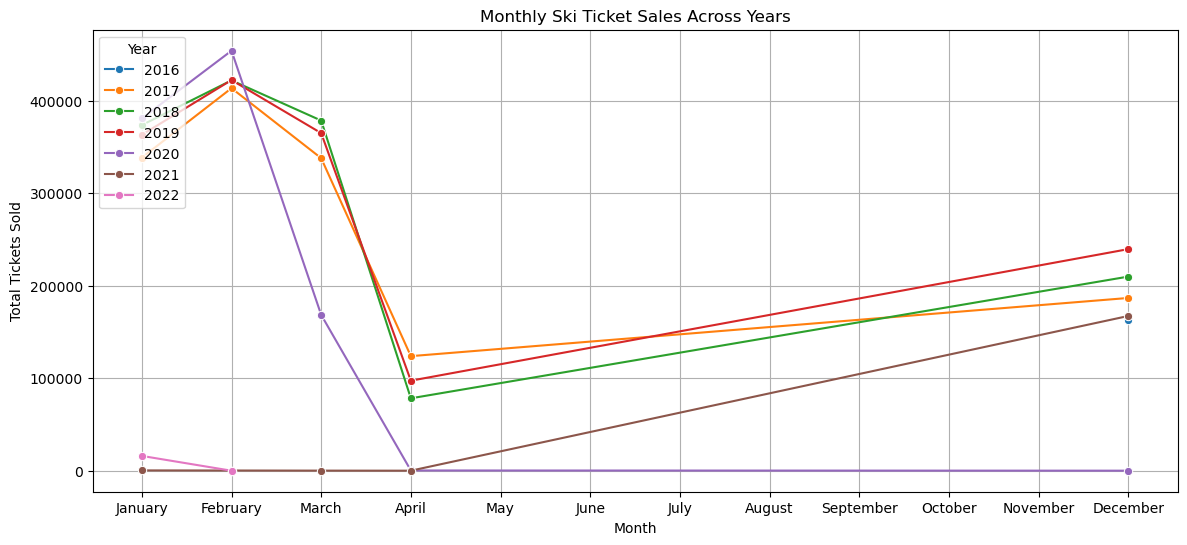

In [11]:
# Aggregate ticket sales by month across all years
monthly_sales = df.groupby(['year', 'month', 'month_text'])['tickets'].sum().reset_index()

# Sort by Year and Month
monthly_sales = monthly_sales.sort_values(by=['year', 'month'])

# Plot total ticket sales by month (across all years)
plt.figure(figsize=(14, 6))
sns.lineplot(data=monthly_sales, x='month', y='tickets', hue='year', marker='o', palette='tab10')
plt.xticks(ticks=range(1, 13), labels=[
    'January', 'February', 'March', 'April', 'May', 'June', 
    'July', 'August', 'September', 'October', 'November', 'December'])
plt.title('Monthly Ski Ticket Sales Across Years')
plt.xlabel('Month')
plt.ylabel('Total Tickets Sold')
plt.legend(title='Year', loc='upper left')
plt.grid(True)
plt.show()

We can see that ski ticket trends were almost similar each year between 2017 and 2019, starting at around 300,000 to 400,000. In 2020, the demand was higher than in the previous years until the pandemic hit. Ticket sales peaked at over 400,000 in February, then started to decline until April before no sales again until December. The peak season is between January and March and lowest month is April

Starting from 03.2020 until 02.2022(not sure about the time of fetching this data), the sales were very low compare for privous yeaons, except 12/2021

In [12]:
df[df['year']==2016]['month_text'].value_counts()

December    25
Name: month_text, dtype: int64

We have data for 2016 only for dec

In [13]:
# we will filter the data in 2016 for lack of data and and corona time
df_filterd = df[df['year']!=2016]
df_filterd = df_filterd[df_filterd['year']<2020]

In [14]:
df_filterd['year'].value_counts()

2019    143
2017    139
2018    134
Name: year, dtype: int64

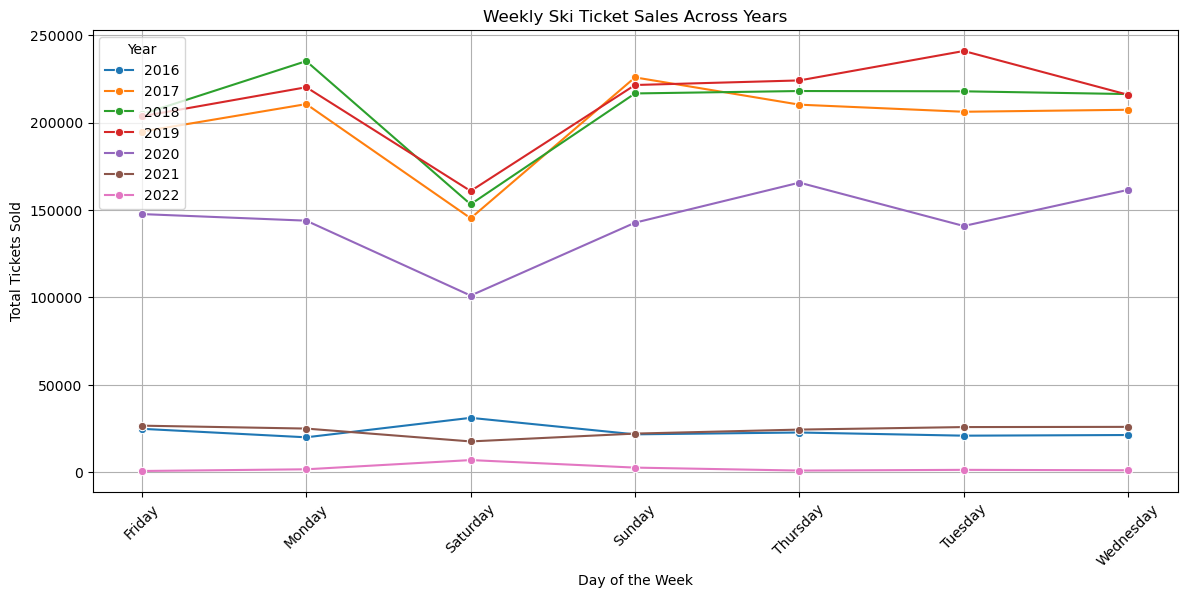

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Aggregate ticket sales by year and day of the week
weekly_sales = df.groupby(['year', 'day_of_week_text'])['tickets'].sum().reset_index()

# Sort by Year and Day of the Week
weekly_sales = weekly_sales.sort_values(by=['year', 'day_of_week_text'])

# Plot total ticket sales by weekday (across all years)
plt.figure(figsize=(14, 6))
sns.lineplot(data=weekly_sales, x='day_of_week_text', y='tickets', hue='year', marker='o', palette='tab10')
plt.title('Weekly Ski Ticket Sales Across Years')
plt.xlabel('Day of the Week')
plt.ylabel('Total Tickets Sold')
plt.legend(title='Year', loc='upper left')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


In [16]:
#Surprisingly, Saturday and Friday are not the busiest days.

In [17]:
X = df[['day_of_week', 'is_weekend', 'month', 'day_of_year', 'year']]
y = df['tickets']

# Filter data for training and testing
train_df = df[df['year'].isin([2017, 2018])]  # Data from 2017 and 2018 for training
test_df = df[df['year'] == 2019]  # Data from 2019 for testing

# Split the training data into features and target
X_train = train_df[['day_of_week', 'is_weekend', 'month', 'day_of_year', 'year']]
y_train = train_df['tickets']

# Split the testing data into features and target
X_test = test_df[['day_of_week', 'is_weekend', 'month', 'day_of_year', 'year']]
y_test = test_df['tickets']

# Train a GradientBoostingRegressor
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.01, max_depth=10, random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set (2019 data)
y_pred = model.predict(X_test).astype(int)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error on 2019 data: {mae}')


Mean Absolute Error on 2019 data: 2354.664335664336


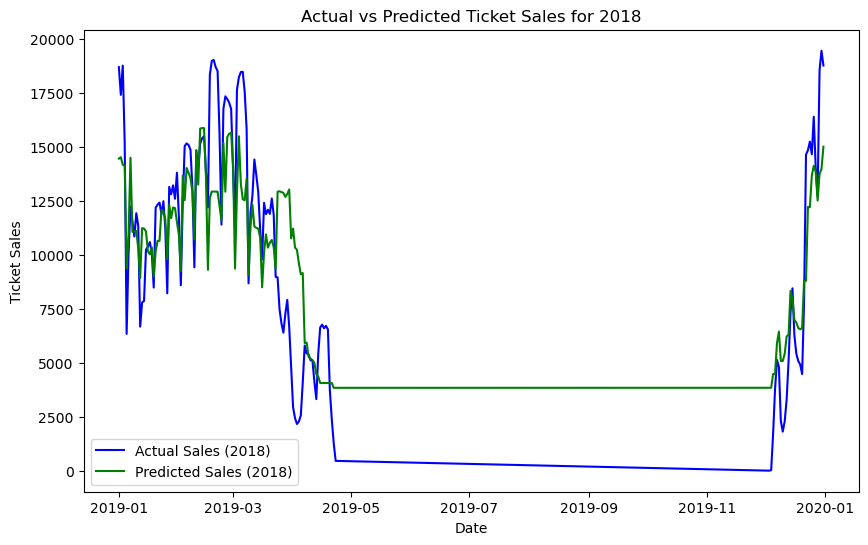

In [18]:
# Optionally, plot the forecasted values for 2019
plt.figure(figsize=(10, 6))
plt.plot(test_df['ski_day'], y_test, label='Actual Sales (2018)', color='blue')
plt.plot(test_df['ski_day'], y_pred, label='Predicted Sales (2018)', color='green')
plt.xlabel('Date')
plt.ylabel('Ticket Sales')
plt.title('Actual vs Predicted Ticket Sales for 2018')
plt.legend()
plt.show()

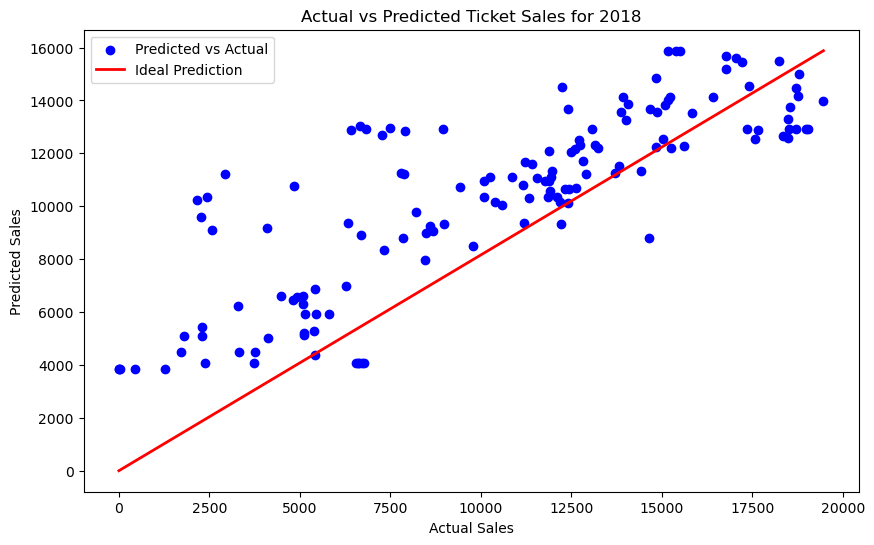

In [19]:

# Plot the actual vs predicted values for the test set (2018 data)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', label='Predicted vs Actual')
plt.plot([0, max(y_test)], [0, max(y_pred)], color='red', lw=2, label='Ideal Prediction')
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Actual vs Predicted Ticket Sales for 2018')
plt.legend()
plt.show()


In [20]:
test_df['tickets_pred']=y_pred

/var/folders/80/b9zrdzkd5mddszqgfxpl60m80000gn/T/ipykernel_23896/87315086.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['tickets_pred']=y_pred


In [21]:
test_df['abs_error'] = abs(test_df['tickets'] - test_df['tickets_pred'])

/var/folders/80/b9zrdzkd5mddszqgfxpl60m80000gn/T/ipykernel_23896/3179207220.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['abs_error'] = abs(test_df['tickets'] - test_df['tickets_pred'])


In [22]:
test_df.to_csv('results.csv', index=False)